In [4]:
import numpy   as np
import scipy   as sp
import matplotlib.pyplot as plt
import ufl
from dolfinx import fem,io,mesh,plot

from ufl import grad,inner,dx,ds,dot
from mpi4py   import MPI
from petsc4py import PETSc

import dolfinx as dfx

from petsc4py.PETSc import ScalarType
import tabulate
import pyvista
from sklearn.linear_model import LinearRegression

In [ ]:
class u_ex:

    def __init__(self, mu):
        self.mu = mu
    
    def __call__(self, x):
        return (np.exp(x[0]/self.mu) - 1)/(np.exp(1/self.mu) - 1)

In [3]:
class CD_problem_2D:
    '''Homogenous Convection-diffusion in 2D with Dirichlet and Neumann BC=0'''
    def __init__(self,mu:float,v:float,u_ex,boundary_D,boundary_N,RHS):
        self.mu=ScalarType(mu)
        self.v=ScalarType(v)
        self.u_ex=u_ex
        self.boundary_D=boundary_D
        self.boundary_N=boundary_N
        self.RHS=RHS
        self.u=None
        self.u_exact=None
        self.V2 = None              #Higher degree element space for more precision for error calcs
        self.mu_float = mu

    def solve(self,N,order=1,SUPG=False,beta=0.5):
        domain=mesh.create_unit_square(MPI.COMM_WORLD,N,N)
        V=fem.FunctionSpace(domain,("CG",1))
        dofs_D=fem.locate_dofs_geometrical(V,self.boundary_D)
        u_bc=fem.Function(V)
        u_bc.interpolate(self.u_ex)
        bc=fem.dirichletbc(value=u_bc,dofs=dofs_D)
        

        u=ufl.TrialFunction(V)
        w=ufl.TestFunction(V)

        mu=fem.Constant(domain,ScalarType(self.mu))
        v = fem.Constant(domain, self.v)

        x=ufl.SpatialCoordinate(domain)
        g=0*x[1]
        f=fem.Constant(domain,ScalarType(self.RHS))

        if SUPG:
            h=1/N
            L = f * w * dx + beta * h * inner(f * v, grad(w)) * dx
            a= mu * dot(grad(u), grad(w)) * dx + dot(v, grad(u) * w) * dx + \
            beta * h*( dot(v, grad(u)) * dot(v, grad(w))) * dx
        else:
            
            L = inner(f, w) * dx
            a = (mu * inner(grad(u), grad(w)) + inner(v, grad(u)) * w) * dx

        
        problem=fem.petsc.LinearProblem(a,L,bcs=[bc],petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

        self.u = problem.solve()

        del domain, V
        return self.u
    
    
    def Interpolate_Exact(self,degree_rise=3):
        V2=fem.FunctionSpace(self.domain,("CG",self.order+degree_rise))
        u_exact=fem.Function(V2)
        u_exact.interpolate(self.u_ex)

        self.V2 = V2
        self.u_exact=u_exact
        print(u_exact.vector.norm(1))
        return u_exact
    
    def Plot(self):
        pyvista.start_xvfb()

        u_topology, u_cell_types, u_geometry = plot.create_vtk_mesh(self.V)
        u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)

        u_grid.point_data["u"] = self.u.x.array.real
        u_grid.set_active_scalars("u")
        u_plotter = pyvista.Plotter()
        u_plotter.add_mesh(u_grid, show_edges=True)
        u_plotter.view_xy()
        if not pyvista.OFF_SCREEN:
            u_plotter.show()
            

    def Plot_Exact(self):
        pyvista.start_xvfb()

        u_topology, u_cell_types, u_geometry = plot.create_vtk_mesh(self.u_exact.function_space)
        u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)

        u_grid.point_data["u"] = self.u_exact.x.array.real
        u_grid.set_active_scalars("u")
        u_plotter = pyvista.Plotter()
        u_plotter.add_mesh(u_grid, show_edges=True)
        u_plotter.view_xy()
        if not pyvista.OFF_SCREEN:
            u_plotter.show()


    def H1_error(self):
        V2=self.V2
        u_h_refined = fem.Function(V2)
        u_h_refined.interpolate(self.u)

        H1_sqr_form = fem.form( ufl.dot(u_h_refined- self.u_exact, u_h_refined- self.u_exact) * ufl.dx + \
                            ufl.dot(ufl.grad(u_h_refined- self.u_exact), ufl.grad(u_h_refined- self.u_exact)) * ufl.dx )
        H1_local = fem.assemble_scalar(H1_sqr_form)
        H1 = np.sqrt(self.u.function_space.mesh.comm.allreduce(H1_local, op=MPI.SUM))
        
        return H1
    
    def L2_error(self,degree_rise = 3):
        V2=self.V2
        u_h_refined = fem.Function(V2)
        u_h_refined.interpolate(self.u)

        L2_error = fem.form(ufl.inner(u_h_refined- self.u_exact, u_h_refined- self.u_exact) * ufl.dx)
        error_local = fem.assemble_scalar(L2_error)
        L2 = np.sqrt(self.domain.comm.allreduce(error_local, op=MPI.SUM))
        return L2
    
    def H1_semi_error(self):
        H1_sqr_form = ufl.dot(ufl.grad(self.u-self.u_exact), ufl.grad(self.u-self.u_exact)) * ufl.dx 
        H1_local = fem.assemble_scalar(H1_sqr_form)
        H1_semi = np.sqrt(self.u.function_space.mesh.comm.allreduce(H1_local, op=MPI.SUM))

        return H1_semi 
    
    def H1_norm_exact(self):
        integrand = fem.form( ufl.dot(self.u_exact, self.u_exact) * ufl.dx + \
                                ufl.dot(ufl.grad(self.u_exact), ufl.grad(self.u_exact)) * ufl.dx)
        H1_local = fem.assemble_scalar(integrand)
        H1 = np.sqrt(self.V2.mesh.comm.allreduce(H1_local, op=MPI.SUM))

        return H1


    def H2_norm_exact(self):

        integrand = fem.form( ufl.dot(self.u_exact, self.u_exact) * ufl.dx + \
                                ufl.dot(ufl.grad(self.u_exact), ufl.grad(self.u_exact)) * ufl.dx + \
                                    ufl.inner(ufl.grad(ufl.grad(self.u_exact)),ufl.grad(ufl.grad(self.u_exact)))*ufl.dx)
        H2_local = fem.assemble_scalar(integrand)
        H2 = np.sqrt(self.V2.mesh.comm.allreduce(H2_local, op=MPI.SUM))

        return H2

    @property 
    def domain(self):
        return self.V.mesh
    
    @property 
    def V(self):
        return self.u.function_space
    
    @property 
    def order(self):
        return self.V.ufl_element().degree()
    
    def numerical_error(self):
        return None

# Test case

Trying to implement a solution, and seeing if it resembles the exponential shape of the analytic solution

In [ ]:
mu=0.01

def boundary_D(x):
    return np.logical_or(np.isclose(x[0], 0), np.isclose(x[0],1))
def boundary_N(x):
    return False
analytic=u_ex(mu)
E0 = CD_problem_2D(mu=0.01, v=(1,0),u_ex=analytic,boundary_D=boundary_D,boundary_N=boundary_N,RHS=0)
#hello=E0.solve(50)
u_exact=E0.Interpolate_Exact()
#E0.Plot()
#E0.Plot_Exact()


NameError: name 'u_ex' is not defined

# Analysis for the standard case

In [7]:
### Creating error tables

def boundary_D(x):
    return np.logical_or(np.isclose(x[0], 0), np.isclose(x[0],1))
def boundary_N(x):
    return False

table_L2 = []
table_H1 = []
for mu in [1, 0.3, 0.1]:
    values_L2=[f"{mu}"]
    values_H1=[f"{mu}"]
    for N in [ 8, 16, 32, 64]:
        
        h=1/N

        analytic=u_ex(mu)
        E0 = CD_problem_2D(mu, v=(1,0),u_ex=analytic,boundary_D=boundary_D,boundary_N=boundary_N,RHS=0)
        u_apx=E0.solve(N,SUPG=False)
        u_exact=E0.Interpolate_Exact()

        L2_error = E0.L2_error()
        values_L2.append(f"{L2_error:.2e}")

        H1_error=E0.H1_error()
        values_H1.append(f"{H1_error:.2e}")
    table_H1.append(values_H1)
    table_L2.append(values_L2)

print("-------------------L2 error-------------------")
print(tabulate.tabulate(table_L2,headers=['mu','1/8','1/16','1/32','1/64']))

print("\n")
print("-------------------H1 error-------------")
print(tabulate.tabulate(table_H1,headers=['mu','1/8','1/16','1/32','1/64']))
    
        

-------------------L2 error-------------------
  mu      1/8      1/16      1/32      1/64
----  -------  --------  --------  --------
 1    0.0014   0.000351  8.77e-05  2.19e-05
 0.3  0.00497  0.00125   0.000314  7.85e-05
 0.1  0.0237   0.00618   0.00156   0.000391


-------------------H1 error-------------
  mu     1/8    1/16     1/32     1/64
----  ------  ------  -------  -------
 1    0.0375  0.0188  0.00938  0.00469
 0.3  0.16    0.0803  0.0402   0.0201
 0.1  0.769   0.398   0.201    0.101


a_H0 = 1.99976, C_H0 = 0.08972
a_H1 = 0.99986, C_H1 = 0.30011
a_H0 = 1.99485, C_H0 = 0.31535
a_H1 = 0.99669, C_H1 = 1.27108
a_H0 = 1.97524, C_H0 = 1.45841
a_H1 = 0.97832, C_H1 = 5.93677


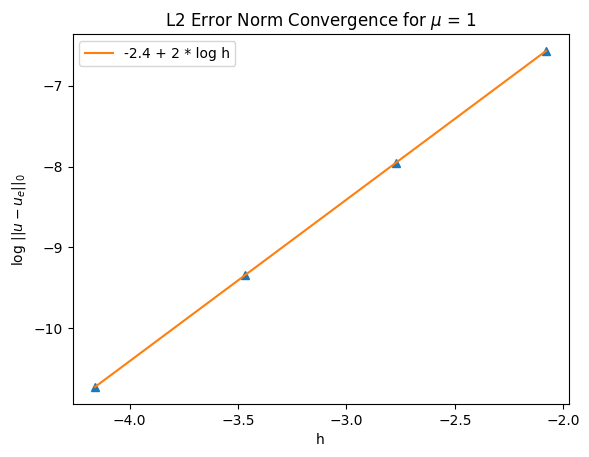

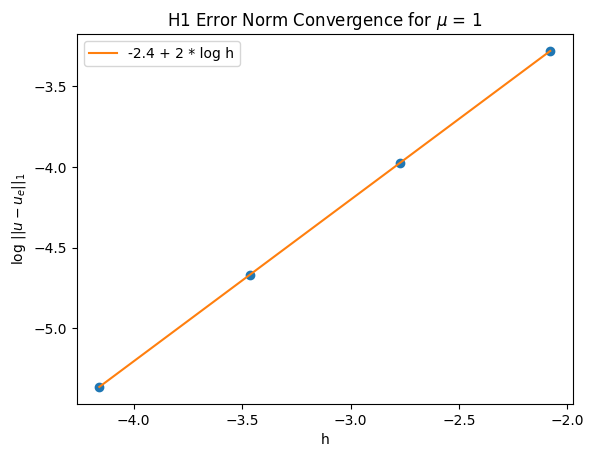

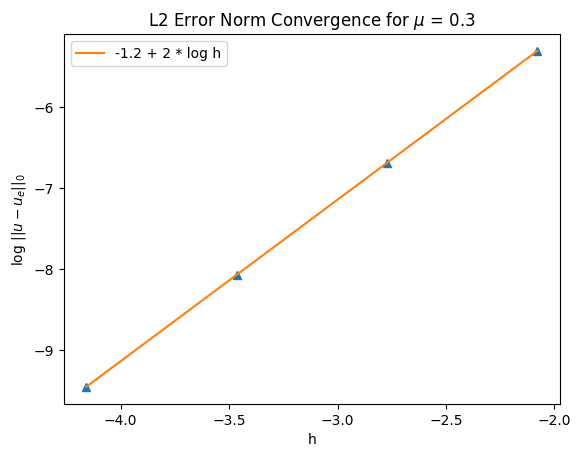

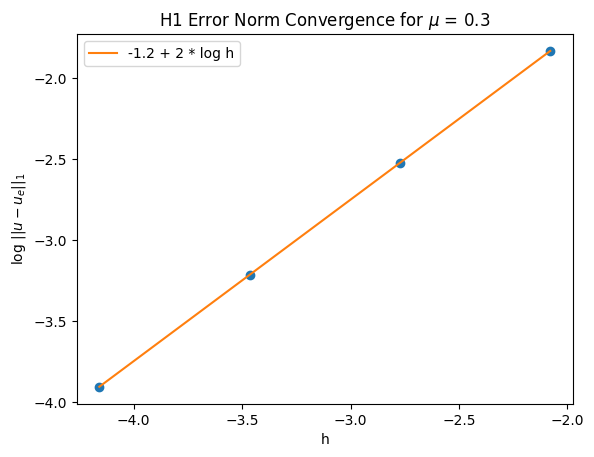

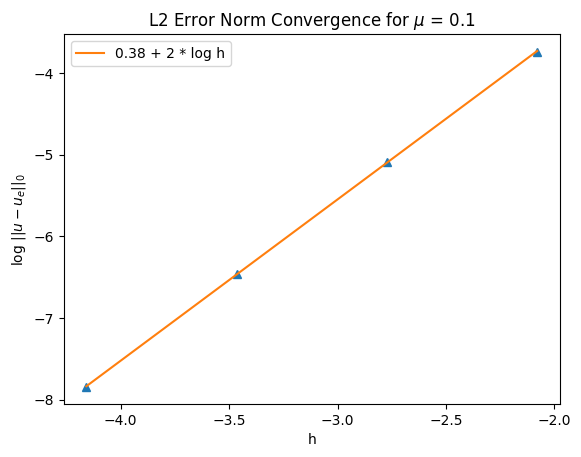

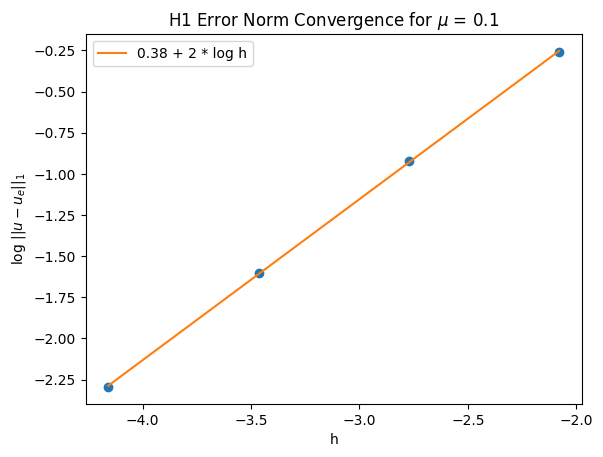

In [8]:
### Creating loglog plots
### Creating error tables

def boundary_D(x):
    return np.logical_or(np.isclose(x[0], 0), np.isclose(x[0],1))
def boundary_N(x):
    return False
X=[]
Y_H1=[]
Y_H0=[]

fig_idx=1
table_L2 = []
table_H1 = []
for mu in [1, 0.3, 0.1]:
    for N in [ 8, 16, 32, 64]:
        
        h=1/N
        X.append(h)

        analytic=u_ex(mu)
        E0 = CD_problem_2D(mu, v=(1,0),u_ex=analytic,boundary_D=boundary_D,boundary_N=boundary_N,RHS=0)
        u_apx=E0.solve(N,SUPG=False)
        u_exact=E0.Interpolate_Exact()

        L2_error = E0.L2_error()
        Y_H0.append(L2_error)

        H1_error=E0.H1_error()
        Y_H1.append(H1_error)

    a_H0, C_H0_log, rho_H0, pval_H0, sd_H0 = sp.stats.linregress(np.log(X), np.log(Y_H0))
    a_H1, C_H1_log, rho_H1, pval_H1, sd_H1 = sp.stats.linregress(np.log(X), np.log(Y_H1))

    C_H0=np.exp(C_H0_log)
    C_H1=np.exp(C_H1_log)

    print(f"a_H0 = {a_H0:.5f}, C_H0 = {C_H0:.5f}")
    print(f"a_H1 = {a_H1:.5f}, C_H1 = {C_H1:.5f}")
    
    plt.figure(fig_idx)
    plt.plot(np.log(X), np.log(Y_H0),'^')
    plt.plot(np.log(X), C_H0_log + a_H0 * np.log(X), label = f"{C_H0_log:.2g} + {a_H0:.2g} * log h")
    plt.title(rf"L2 Error Norm Convergence for $\mu$ = {mu}")
    plt.xlabel("h")
    plt.ylabel("log $||u-u_e||_0$")
    plt.legend()
    plt.savefig(rf'L2_mu={mu}.png')

    plt.figure(fig_idx + 1)
    plt.plot(np.log(X), np.log(Y_H1),'o')
    plt.plot(np.log(X), C_H1_log + a_H1 * np.log(X), label = f"{C_H0_log:.2g} + {a_H0:.2g} * log h")
    plt.title(rf"H1 Error Norm Convergence for $\mu$ = {mu}")
    plt.xlabel("h")
    plt.ylabel("log $||u-u_e||_1$")
    plt.legend()
    plt.savefig(rf'H1_mu={mu}.png')
    fig_idx += 2
    X=[]
    Y_H1=[]
    Y_H0=[]

# Analysis for the SUPG case

In [ ]:
### Creating error tables

def boundary_D(x):
    return np.logical_or(np.isclose(x[0], 0), np.isclose(x[0],1))
def boundary_N(x):
    return False

table_L2 = []
table_H1 = []
for mu in [1, 0.3, 0.1]:
    values_L2=[f"{mu}"]
    values_H1=[f"{mu}"]
    for N in [ 8, 16, 32, 64]:
        
        h=1/N

        analytic=u_ex(mu)
        E0 = CD_problem_2D(mu, v=(1,0),u_ex=analytic,boundary_D=boundary_D,boundary_N=boundary_N,RHS=0)
        u_apx=E0.solve(N,SUPG=True)
        u_exact=E0.Interpolate_Exact()

        L2_error = E0.L2_error()
        values_L2.append(f"{L2_error:.2e}")

        H1_error=E0.H1_error()
        values_H1.append(f"{H1_error:.2e}")
    table_H1.append(values_H1)
    table_L2.append(values_L2)

print("-------------------L2 error-------------------")
print(tabulate.tabulate(table_L2,headers=['mu','1/8','1/16','1/32','1/64']))

print("\n")
print("-------------------H1 error-------------")
print(tabulate.tabulate(table_H1,headers=['mu','1/8','1/16','1/32','1/64']))
    

-------------------L2 error-------------------
  mu      1/8     1/16     1/32      1/64
----  -------  -------  -------  --------
 1    0.00624  0.00292  0.00141  0.000694
 0.3  0.0384   0.0198   0.0101   0.00511
 0.1  0.0885   0.0463   0.0238   0.0121


-------------------H1 error-------------
  mu     1/8    1/16    1/32     1/64
----  ------  ------  ------  -------
 1    0.0413  0.0208  0.0104  0.00523
 0.3  0.211   0.112   0.0579  0.0294
 0.1  0.901   0.531   0.29    0.152


a_H0 = 1.05582, C_H0 = 0.05537
a_H1 = 0.99458, C_H1 = 0.32742
a_H0 = 0.97020, C_H0 = 0.29028
a_H1 = 0.94900, C_H1 = 1.53808
a_H0 = 0.95686, C_H0 = 0.65215
a_H1 = 0.85686, C_H1 = 5.52003


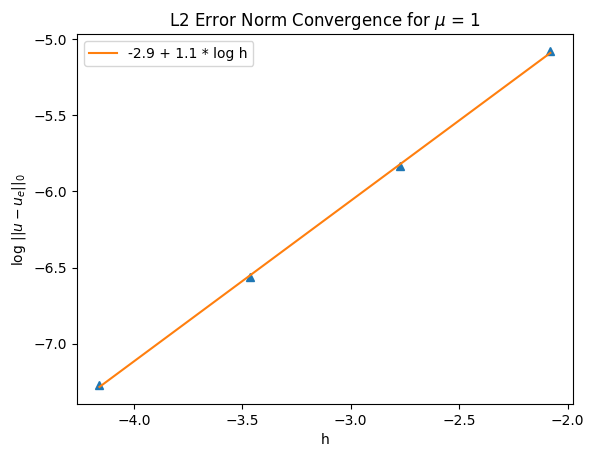

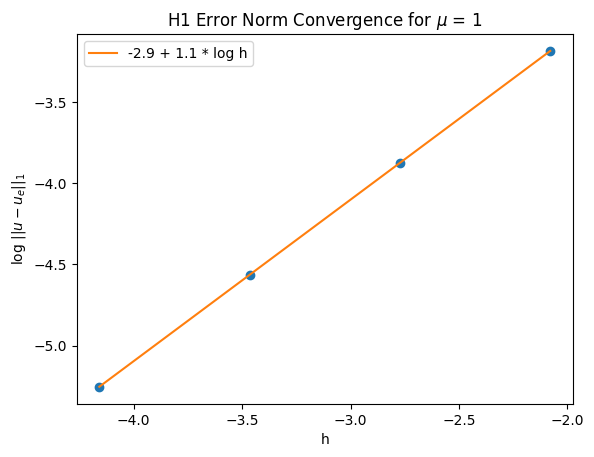

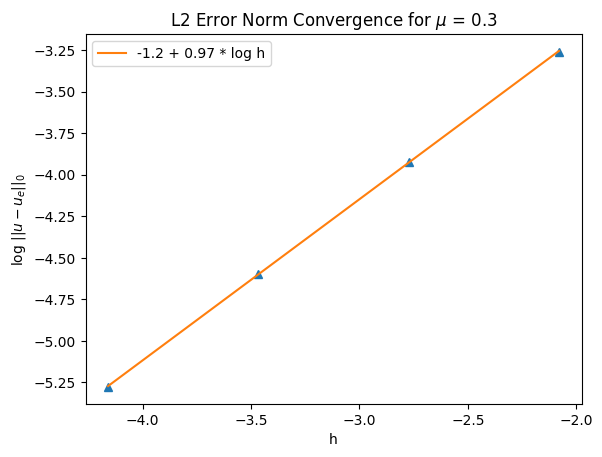

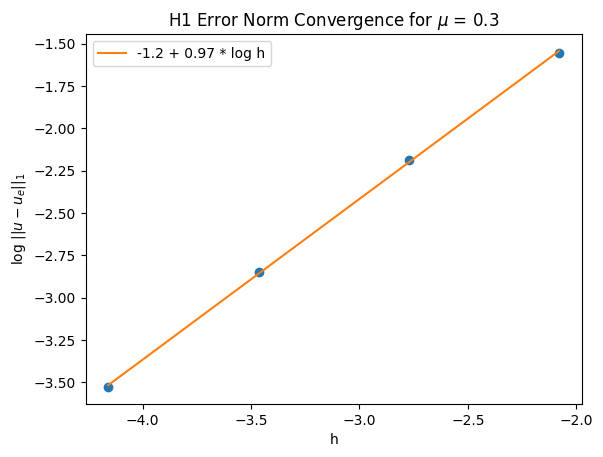

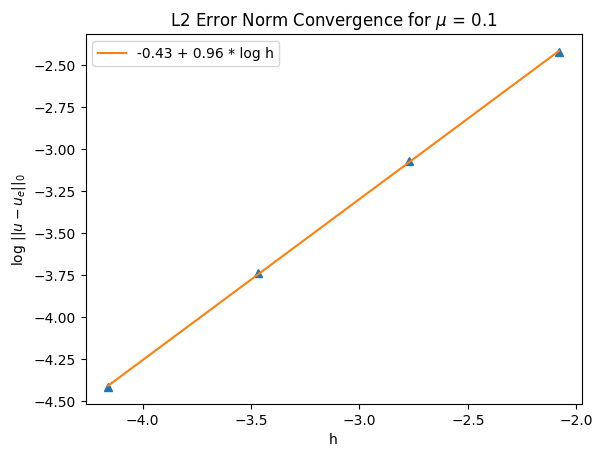

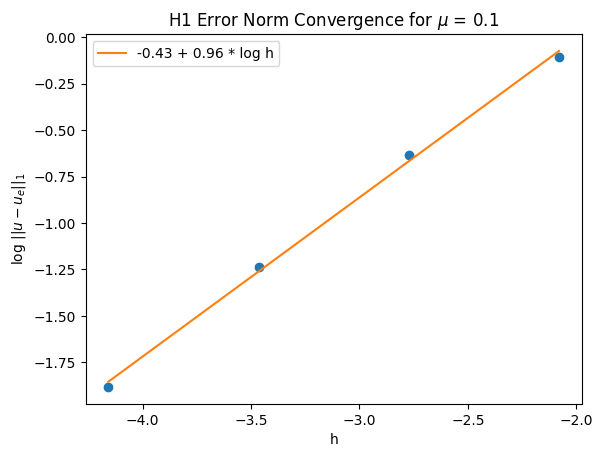

In [9]:
### Creating loglog plots
### Creating error tables

def boundary_D(x):
    return np.logical_or(np.isclose(x[0], 0), np.isclose(x[0],1))
def boundary_N(x):
    return False
X=[]
Y_H1=[]
Y_H0=[]

fig_idx=1
table_L2 = []
table_H1 = []
for mu in [1, 0.3, 0.1]:
    for N in [ 8, 16, 32, 64]:
        
        h=1/N
        X.append(h)

        analytic=u_ex(mu)
        E0 = CD_problem_2D(mu, v=(1,0),u_ex=analytic,boundary_D=boundary_D,boundary_N=boundary_N,RHS=0)
        u_apx=E0.solve(N,SUPG=True)
        u_exact=E0.Interpolate_Exact()

        L2_error = E0.L2_error()
        Y_H0.append(L2_error)

        H1_error=E0.H1_error()
        Y_H1.append(H1_error)

    a_H0, C_H0_log, rho_H0, pval_H0, sd_H0 = sp.stats.linregress(np.log(X), np.log(Y_H0))
    a_H1, C_H1_log, rho_H1, pval_H1, sd_H1 = sp.stats.linregress(np.log(X), np.log(Y_H1))

    C_H0=np.exp(C_H0_log)
    C_H1=np.exp(C_H1_log)

    print(f"a_H0 = {a_H0:.5f}, C_H0 = {C_H0:.5f}")
    print(f"a_H1 = {a_H1:.5f}, C_H1 = {C_H1:.5f}")
    
    plt.figure(fig_idx)
    plt.plot(np.log(X), np.log(Y_H0),'^')
    plt.plot(np.log(X), C_H0_log + a_H0 * np.log(X), label = f"{C_H0_log:.2g} + {a_H0:.2g} * log h")
    plt.title(rf"L2 Error Norm Convergence for $\mu$ = {mu}")
    plt.xlabel("h")
    plt.ylabel("log $||u-u_e||_0$")
    plt.legend()
    plt.savefig(rf'L2_mu={mu}.png')

    plt.figure(fig_idx + 1)
    plt.plot(np.log(X), np.log(Y_H1),'o')
    plt.plot(np.log(X), C_H1_log + a_H1 * np.log(X), label = f"{C_H0_log:.2g} + {a_H0:.2g} * log h")
    plt.title(rf"H1 Error Norm Convergence for $\mu$ = {mu}")
    plt.xlabel("h")
    plt.ylabel("log $||u-u_e||_1$")
    plt.legend()
    plt.savefig(rf'H1_mu={mu}.png')
    fig_idx += 2
    X=[]
    Y_H1=[]
    Y_H0=[]

Seems like you have improved linearity with the SUPG method for the error, which is to be expected since you're operating with a more stable scheme with less oscillations